In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks

In [975]:
fname = 'run11-2-spot34.DTA.csv'
path = 'CV/'+fname
R = 46.62

i = 0; i5 = 0
with open(path, 'r') as f:
    for line in f:
        i+=1
        if line[:6] == 'CURVE5':
            i5 = (i+2)
MIDPOINT_I = i5 + 949

            V         I
7676  0.00450 -0.000301
7677  0.00650 -0.000297
7678  0.00849 -0.000295
7679  0.01050 -0.000295
7680  0.01250 -0.000292
...       ...       ...
8620  1.89000  0.001860
8621  1.89000  0.001880
8622  1.89000  0.001890
8623  1.90000  0.001910
8624  1.90000  0.001930

[949 rows x 2 columns]


<Axes: xlabel='V', ylabel='I'>

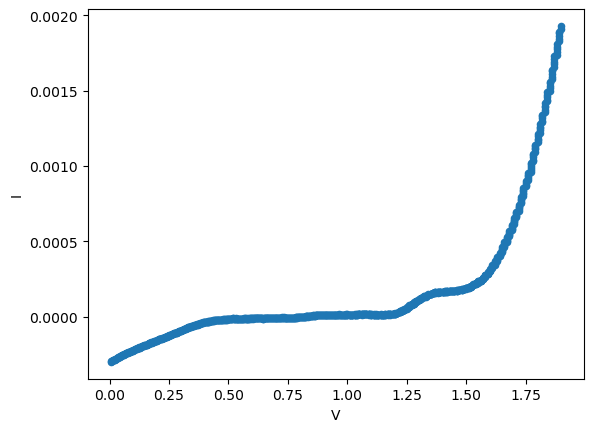

In [976]:
df = pd.read_csv(path)
t5 = df.iloc[i5:MIDPOINT_I,3:5] #Just 1/2 the 5th cycle
t5.columns = ['V','I']
t5['V'] = pd.to_numeric(t5['V'])
t5['I'] = pd.to_numeric(t5['I'])
print(t5)
t5.plot.scatter(x='V',y='I')

In [977]:
t5 = t5[t5['I'] >= 0] #Drop all current values less than 0

In [978]:
#make di/dv
c = t5['I'].tolist()
v = t5['V'].tolist()
#dv = 0.002 #needs to be corrected
t=0
for i in range(0,len(v)):
    if v[i] == 1 and t == 0:
        t = i
    elif v[i] >= 1:
        v[i] = 1 + 0.002*(i-t)
#print(v)

#current needs to be smoothed
#Savitzky-Golay filter to smooth the data
window = 5
polyorder = 1
c_smooth = savgol_filter(c, window, polyorder)

In [979]:
#Vcorrected=V-IR
for i in range(0,len(v)):
    v[i] = v[i] - c_smooth[i]*R

#didv
didv = np.diff(c_smooth)/np.diff(v)
v = v[1:]

#log(abs(di/dv)) vs V
log_didv = np.log10(np.abs(didv))

/var/folders/dv/sr8qvvk96f77nzy3nk2r336c0000gn/T/ipykernel_47260/4172382663.py:10: RuntimeWarning: divide by zero encountered in log10
  log_didv = np.log10(np.abs(didv))


In [980]:
#drop inf and nan data. filtered f
vf = []; ldidvf = []
for i in range(0, len(log_didv)):
    if not math.isnan(log_didv[i]) and not math.isinf(log_didv[i]):
        vf.append(v[i])
        ldidvf.append(log_didv[i])
        

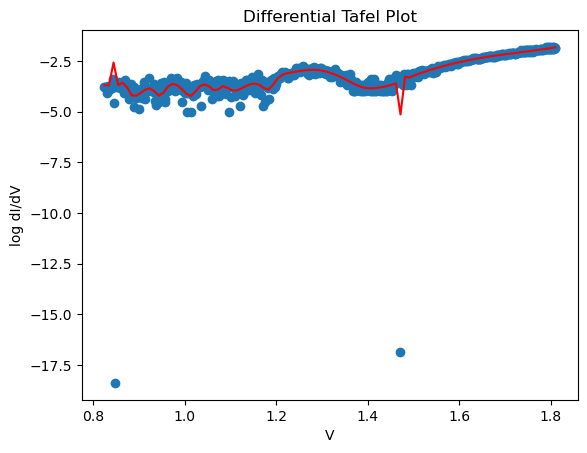

In [981]:
#GOAL: calculate Vmax (if possible) and slope onset and v onset;
#1) fit a curve (spline since I don't know the curve function)
si = np.argsort(vf)
vf = np.array(vf)[si]
ldidvf = np.array(ldidvf)[si]
spline = UnivariateSpline(vf, ldidvf, s=30)

x_fit = np.linspace(min(vf), max(vf), 100)
y_fit = spline(x_fit)

plt.scatter(vf, ldidvf)
plt.plot(x_fit, y_fit, label='Fitted Curve', color='red')
plt.title('Differential Tafel Plot')
plt.xlabel('V')
plt.ylabel('log dI/dV')
plt.show()

In [982]:
df = pd.DataFrame({'V': vf, 'log(dI/dV)': ldidvf})
df.to_csv('tafel/tafel-'+fname, index=False)